**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import wget
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearnex import patch_sklearn, config_context
patch_sklearn()

%matplotlib inline

C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

100% [..........................................................................] 1423529 / 1423529

'housing.csv'

In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [4]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [5]:
# for column names:

df.columns = df.columns.str.lower().str.replace(' ', '_')

# for data in the dataframe:

strings = list(df.dtypes[df.dtypes == 'object'].index)
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.head(5).T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,near_bay,near_bay,near_bay,near_bay,near_bay


In [6]:
# checking if any missing values exist in any of the missing columns:
df.isna().sum(axis=0)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
# column_names = df.columns[df.isnull().any()].to_list()

# for column in column_names:
#     df[column].fillna(0, inplace=True) 
    
# df.isna().sum(axis=0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [8]:
features = df.drop(columns='median_house_value')
features.head()
target = df["median_house_value"]
target.head()
log_target = np.log1p(target)
log_target

0        13.022766
1        12.789687
2        12.771673
3        12.740520
4        12.743154
           ...    
20635    11.265758
20636    11.252872
20637    11.432810
20638    11.346883
20639    11.400887
Name: median_house_value, Length: 20640, dtype: float64

In [9]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:

from sklearn.model_selection import train_test_split


x_train_full, x_test, y_train_full, y_test = train_test_split(features, log_target, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=1)

splits = [x_train_full, x_train, x_val, x_test]
for split in splits:
        split.reset_index(inplace = True)

splits = [y_train_full,y_train, y_val, y_test]
for split in splits:
         split.reset_index(drop = True, inplace = True)    
       

- We will use `DictVectorizer` to turn train and validation into matrices.

In [10]:
#@ IMPLEMENTATION OF DICTVECTORIZER:

dv = DictVectorizer(sparse=False)

train_dict = x_train.to_dict(orient='records')
x_train_OH = dv.fit_transform(train_dict)

val_dict = x_val.to_dict(orient='records')
x_val_OH = dv.transform(val_dict)


**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [12]:
#@ TRAINING THE REGRESSION MODEL:

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(x_train_OH, y_train)
y_pred = dt.predict(x_val_OH)

In [13]:
#@ INSPECTION:

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=inland <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=inland >  0.50
|   |--- value: [11.61]



C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer: **ocean_proximity=inland**

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [14]:
#@ TRAINING RANDOM FOREST MODEL:

n_estimators=10  
random_state=1  
n_jobs=-1 

rf = RandomForestRegressor(n_estimators=n_estimators,
                            random_state=random_state,
                           n_jobs = n_jobs)
rf.fit(x_train_OH, y_train)
y_pred = rf.predict(x_val_OH)

In [15]:
#@ CALCULATING MEAN SQUARED ERROR:
# squaredbool, default=True
#    If True returns MSE value, if False returns RMSE value.

round(mean_squared_error(y_val, y_pred, squared=False),3)

0.237

- What's the RMSE of this model on validation?

- Answer: **0.237**

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [17]:
#@ TRAINING THE RANDOM FOREST MODEL:

scores = []
range_n_estimators = np.arange(10, 210, 10)

for n_est in range_n_estimators:
    
        rf = RandomForestRegressor(n_estimators=n_est,
                                    random_state=1,
                                    n_jobs = -1)
        rf.fit(x_train_OH, y_train)

        y_pred = rf.predict(x_val_OH)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        scores.append((n_est,rmse))
        
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
df_scores

,n_estimators,RMSE
0,10,0.236755
1,20,0.229005
2,30,0.226680
3,40,0.226321
4,50,0.226023
5,60,0.225379
6,70,0.224517
7,80,0.224515
8,90,0.224199
9,100,0.224151


Text(0, 0.5, 'RMSE')

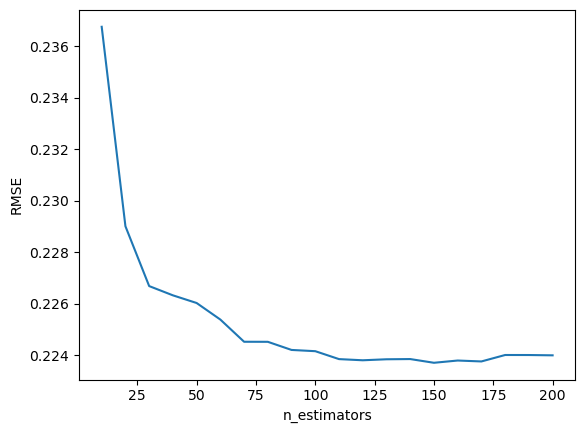

In [18]:
#@ INSPECTING THE RMSE SCORES:

plt.plot(df_scores.n_estimators, df_scores.RMSE)
plt.xlabel("n_estimators")
plt.ylabel("RMSE")

- After which value of `n_estimators` does RMSE stop improving?

- Answer: **150**

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [19]:
#@ TRAINING THE MODEL WITH DEPTH:

scores = []
max_depth = [10, 15, 20, 25]
range_n_estimators = np.arange(10, 210, 10)

for d in max_depth:
    for n_est in range_n_estimators:

            rf = RandomForestRegressor(n_estimators=n_est,
                                        max_depth= d,
                                        random_state=1,
                                        n_jobs = -1)
            rf.fit(x_train_OH, y_train)

            y_pred = rf.predict(x_val_OH)
            rmse = mean_squared_error(y_val, y_pred, squared=False)

            scores.append((d, n_est,rmse))
    

In [20]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,RMSE
0,10,10,0.253136
1,10,20,0.250160
2,10,30,0.250099
3,10,40,0.249999
4,10,50,0.250147
...,...,...,...
75,25,160,0.223528
76,25,170,0.223510
77,25,180,0.223809
78,25,190,0.223822


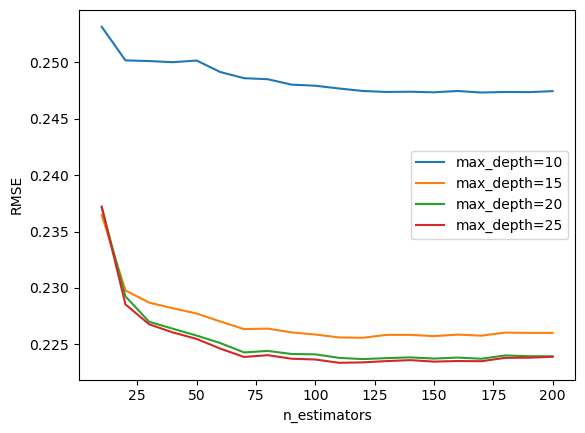

In [21]:
for d in max_depth:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
             label='max_depth=%d' % d)
    
    
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.legend()

- What's the best `max_depth`:

- Answer: **25**

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [22]:
#@ TRAINING THE RANDOM FOREST MODEL:

n_estimators=10
max_depth=20
random_state=1  
n_jobs=-1 

rf = RandomForestRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           random_state=random_state,
                           n_jobs = n_jobs)
rf.fit(x_train_OH, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)



C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


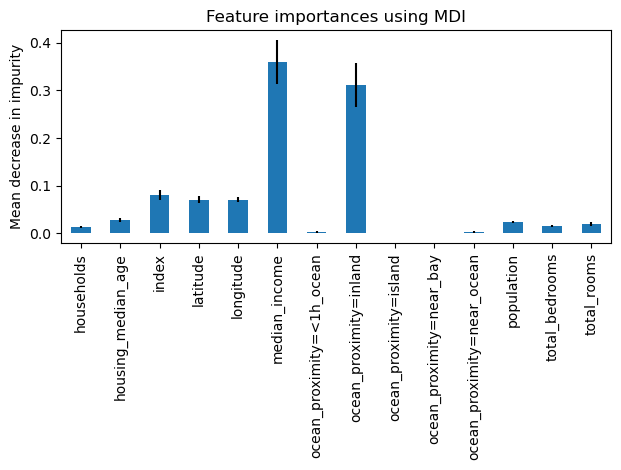

In [23]:
forest_importances = pd.Series(importances, index= dv.get_feature_names())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- What's the most important feature?

- Answer: **median_income**

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [24]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_
features

['households',
 'housing_median_age',
 'index',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1h_ocean',
 'ocean_proximity=inland',
 'ocean_proximity=island',
 'ocean_proximity=near_bay',
 'ocean_proximity=near_ocean',
 'population',
 'total_bedrooms',
 'total_rooms']

In [25]:
# ValueError: feature_names must be string, and may not contain [, ] or <

In [26]:
regex = re.compile(r"=<|\[|\]", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('=','<','[', ']'))) else col for col in features]
features

['households',
 'housing_median_age',
 'index',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_1h_ocean',
 'ocean_proximity=inland',
 'ocean_proximity=island',
 'ocean_proximity=near_bay',
 'ocean_proximity=near_ocean',
 'population',
 'total_bedrooms',
 'total_rooms']

In [27]:
dtrain = xgb.DMatrix(x_train_OH, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val_OH, label=y_val, feature_names=features)

In [31]:
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}


# xgb_param['eval_metric'] = 'rmse'
watchlist = [(dtrain, 'train'), (dval, 'eval')]

num_round = 100
bst = xgb.train(xgb_params, dtrain, num_round, watchlist)

[0]	train-rmse:8.12733	eval-rmse:8.13245
[1]	train-rmse:5.69586	eval-rmse:5.70070
[2]	train-rmse:3.99534	eval-rmse:3.99961
[3]	train-rmse:2.80673	eval-rmse:2.81054
[4]	train-rmse:1.97720	eval-rmse:1.98060
[5]	train-rmse:1.40055	eval-rmse:1.40602
[6]	train-rmse:0.99978	eval-rmse:1.00616
[7]	train-rmse:0.72601	eval-rmse:0.73398
[8]	train-rmse:0.54258	eval-rmse:0.55300
[9]	train-rmse:0.41736	eval-rmse:0.42933
[10]	train-rmse:0.33893	eval-rmse:0.35412
[11]	train-rmse:0.29138	eval-rmse:0.30958
[12]	train-rmse:0.26111	eval-rmse:0.28264
[13]	train-rmse:0.24329	eval-rmse:0.26688
[14]	train-rmse:0.23230	eval-rmse:0.25818
[15]	train-rmse:0.22253	eval-rmse:0.25095
[16]	train-rmse:0.21892	eval-rmse:0.24870
[17]	train-rmse:0.21494	eval-rmse:0.24610
[18]	train-rmse:0.21136	eval-rmse:0.24455
[19]	train-rmse:0.20852	eval-rmse:0.24297
[20]	train-rmse:0.20725	eval-rmse:0.24240
[21]	train-rmse:0.20616	eval-rmse:0.24173
[22]	train-rmse:0.20181	eval-rmse:0.23875
[23]	train-rmse:0.20098	eval-rmse:0.23887
[2

In [32]:
y_pred = bst.predict(dval)
rmse = mean_squared_error(y_val,y_pred, squared= False)
rmse

0.2195412561585616

- Now, change eta first to 0.1 and then to 0.01.

In [33]:
eta_list =  [0.1,0.01]
RMSE = []

for eta in eta_list:
    xgb_params['eta'] = eta
    num_round = 100
    print ("Training with eta %0.3f:\n\n" %(eta))
    bst = xgb.train(xgb_params, dtrain, num_round, watchlist)
    print ("\n\n")
    y_pred = bst.predict(dval)
    rmse = mean_squared_error(y_val,y_pred, squared= False)
    RMSE.append(rmse)


print("Training complete\n\n")
for i,eta in enumerate(eta_list):
    print ("For eta %0.3f, RMSE is %0.5f " %(eta, RMSE[i]))    


Training with eta 0.100:


[0]	train-rmse:10.44371	eval-rmse:10.44938
[1]	train-rmse:9.40118	eval-rmse:9.40684
[2]	train-rmse:8.46290	eval-rmse:8.46831
[3]	train-rmse:7.61859	eval-rmse:7.62391
[4]	train-rmse:6.85878	eval-rmse:6.86368
[5]	train-rmse:6.17513	eval-rmse:6.17987
[6]	train-rmse:5.55992	eval-rmse:5.56416
[7]	train-rmse:5.00639	eval-rmse:5.01018
[8]	train-rmse:4.50838	eval-rmse:4.51201
[9]	train-rmse:4.06030	eval-rmse:4.06384
[10]	train-rmse:3.65719	eval-rmse:3.66051
[11]	train-rmse:3.29460	eval-rmse:3.29767
[12]	train-rmse:2.96847	eval-rmse:2.97146
[13]	train-rmse:2.67518	eval-rmse:2.67816
[14]	train-rmse:2.41155	eval-rmse:2.41423
[15]	train-rmse:2.17452	eval-rmse:2.17720
[16]	train-rmse:1.96127	eval-rmse:1.96403
[17]	train-rmse:1.76988	eval-rmse:1.77244
[18]	train-rmse:1.59791	eval-rmse:1.60080
[19]	train-rmse:1.44355	eval-rmse:1.44665
[20]	train-rmse:1.30443	eval-rmse:1.30770
[21]	train-rmse:1.18002	eval-rmse:1.18332
[22]	train-rmse:1.06853	eval-rmse:1.07243
[23]	train-rmse

[94]	train-rmse:4.47900	eval-rmse:4.48263
[95]	train-rmse:4.43448	eval-rmse:4.43807
[96]	train-rmse:4.39040	eval-rmse:4.39395
[97]	train-rmse:4.34677	eval-rmse:4.35028
[98]	train-rmse:4.30357	eval-rmse:4.30704
[99]	train-rmse:4.26081	eval-rmse:4.26426



Training complete


For eta 0.100, RMSE is 0.22691 
For eta 0.010, RMSE is 4.26426 


- Which eta leads to the best RMSE score on the validation dataset?
-Answer:
     
     - RMSE of 0.01 is worst at 4.26426, 
     - for 0.1 it is 0.22691, 
     - whereas 0.3 gives best RMSE of 0.21954